# Input-Output Generation

In [1]:
! pip install control

In [2]:
import control as ctrl
import math
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class DataGenerator:

	def __init__(
		self,
		n_config,			# select TF configuration
		sampling_rate=100, 	# sampling of the signals
		time_length=9,		# length of the simulation (no leading 0)
		initial_zero=1,		# length is seconds of initial 0
		fixed_period_n=True,
	):
		# store values
		self.sampling_freq = 1/sampling_rate
		self.time_length = time_length
		self.initial_zero = initial_zero
		self.fixed_period_n = fixed_period_n,

		# select configuration
		s = ctrl.tf('s')
		if n_config == 0:
			self.G = 2**2 / (s**2 + 2*0.3*2*s + 2**2)
		elif n_config == 1:
			self.G = 2**2 / (s**2 + 2*0.3*2*s + 2**2) + 7**2 / (s**2 + 2*0.6*7*s + 7**2)
		elif n_config == 2:
			self.G = (s**2 - 3*s - 4) / (s**2 + 5*s + 6)
		else:
			raise Exception("Invalid configuration number")

		print(f"TF: {self.G}")


	def sine_wave_response(self, freq, silent=True):
		return self.response(0, freq, float('NaN'), silent)


	def impulse_response(self, ampl=10, silent=True):
		return self.response(1, float('NaN'), ampl, silent)


	def response(self, type, freq, ampl, silent=True):
		t_zero = np.arange(0, self.initial_zero, self.sampling_freq)
		t_sim = np.arange(self.initial_zero, self.initial_zero+self.time_length, self.sampling_freq)

		if type == 0 and self.fixed_period_n:
			time_period = 1/freq
			periods_n = self.time_length / time_period
			remaining_period_fraction = periods_n - math.floor(periods_n)
			if remaining_period_fraction != 1e-4:
				missing_part = (1 - remaining_period_fraction) * time_period
				t_addition = np.arange(self.initial_zero+self.time_length, self.initial_zero+self.time_length+missing_part, self.sampling_freq)
				t_sim = np.hstack((t_sim, t_addition))

		t = np.hstack((t_zero, t_sim))

		leading_zero = np.zeros(len(t_zero), dtype=float)
		if type == 0:
			input_signal = np.sin(2 * np.pi * freq * (t_sim - self.initial_zero))
		elif type == 1:
			input_signal = np.zeros_like(t_sim)
			input_signal[0] = ampl
		else:
			raise Exception("Invalid response type")
		u = np.hstack((leading_zero, input_signal))

		t_resp, y = ctrl.forced_response(self.G, T=t, U=u)

		if not silent:
			plt.figure()
			plt.plot(t, y, label="output")
			if type != 1:
				plt.plot(t, u, label="input", linestyle="--")
			plt.legend()
		
		return {'time': t, 'input': u, 'response': y}

TF: <TransferFunction>: sys[9]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


       4
---------------
s^2 + 1.2 s + 4



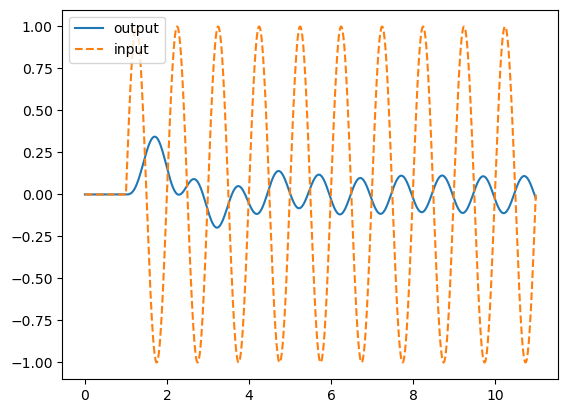

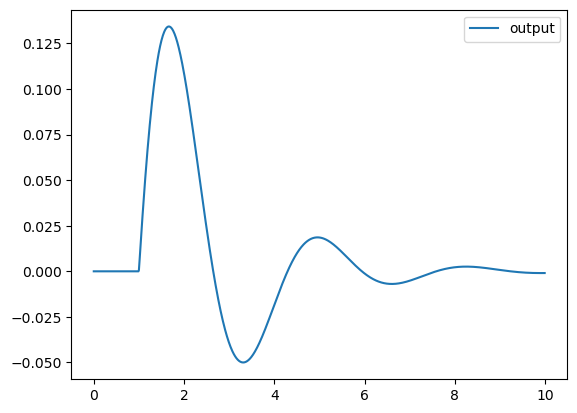

In [4]:
dg = DataGenerator(0)
_ = dg.sine_wave_response(1.001, silent=False)
_ = dg.impulse_response(silent=False)

# Multi-step LSTM

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

import os
from IPython.display import clear_output
from tqdm import tqdm

## Network Definitions

### Dataset

In [6]:
class TimeSeriesDataset(Dataset):
    
    def __init__(self, input_data, output_data, seq_len, pred_steps):
        self.input_data = torch.FloatTensor(input_data)
        self.output_data = torch.FloatTensor(output_data)
        self.seq_len = seq_len
        self.pred_steps = pred_steps
        
    def __len__(self):
        return len(self.input_data) - self.seq_len - self.pred_steps + 1
    
    def __getitem__(self, idx):
        # get input and corresponding output sequence
        X = self.input_data[idx : idx+self.seq_len]
        y = self.output_data[idx+self.seq_len : idx+self.seq_len+self.pred_steps]
        return X, y

### Network

In [7]:
class DynamicalSystemModel(nn.Module):
    
	def __init__(self, type, input_size, hidden_size, num_layers, output_size, dropout=0.1):
		super(DynamicalSystemModel, self).__init__()
		self.type = type
		self.hidden_size = hidden_size
		self.num_layers = num_layers

		if type == "lstm":
			self.net = nn.LSTM(
				input_size=input_size,
				hidden_size=hidden_size,
				num_layers=num_layers,
				batch_first=True,
				dropout=dropout if num_layers > 1 else 0
			)
		elif type == "gru":
			self.net = nn.GRU(
				input_size=input_size,
				hidden_size=hidden_size,
				num_layers=num_layers,
				batch_first=True,
				dropout=dropout if num_layers > 1 else 0
			)
		else:
			raise NotImplementedError

		self.fc = nn.Linear(hidden_size, output_size)

	def forward(self, x):
		batch_size = x.size(0)

		# forward propagate
		out, _ = self.net(x)
		out = self.fc(out[:, -1, :])

		return out
	
	def str_id(self):
		return f"{self.type}_{self.num_layers}_{self.hidden_size}"

### Training

In [8]:
def plot_losses(train_losses, val_losses, title='Training Progress'):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.yscale('log')  # Log scale often better for loss visualization
    
    # Add min loss annotations
    min_train_loss = min(train_losses)
    min_val_loss = min(val_losses)
    plt.annotate(f'Min Train Loss: {min_train_loss:.4f}', 
                xy=(train_losses.index(min_train_loss), min_train_loss),
                xytext=(10, 10), textcoords='offset points')
    plt.annotate(f'Min Val Loss: {min_val_loss:.4f}', 
                xy=(val_losses.index(min_val_loss), min_val_loss),
                xytext=(10, -10), textcoords='offset points')
    
    plt.tight_layout()
    
def plot_training_progress(train_losses, val_losses, epoch, num_epochs, clear=True):
    if clear:
        clear_output(wait=True)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Progress (Epoch {epoch+1}/{num_epochs})')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.yscale('log')
    
    # Add current loss values
    if train_losses and val_losses:
        plt.annotate(f'Train Loss: {train_losses[-1]:.4f}', 
                    xy=(len(train_losses)-1, train_losses[-1]),
                    xytext=(10, 10), textcoords='offset points')
        plt.annotate(f'Val Loss: {val_losses[-1]:.4f}', 
                    xy=(len(val_losses)-1, val_losses[-1]),
                    xytext=(10, -10), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, early_stop_patience=5, folder="pytorch_models"):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Training Epochs'):
        # training phase
        model.train()
        tot_train_loss = 0
        batch_size = len(train_loader)
        
        for batch_idx, (in_data, out_data) in enumerate(train_loader):
            in_data, out_data = in_data.to(device), out_data.to(device)
            
            # forward pass
            optimizer.zero_grad()
            model_output = model(in_data)
            loss = criterion(model_output.unsqueeze(1), out_data)
            
            # backward pass
            loss.backward()
            optimizer.step()
            
            tot_train_loss += loss.item()
            
        avg_train_loss = tot_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # validation phase
        model.eval()
        tot_val_loss = 0
        with torch.no_grad():
            for in_data, out_data in val_loader:
                in_data, out_data = in_data.to(device), out_data.to(device)
                model_output = model(in_data)
                loss = criterion(model_output.unsqueeze(1), out_data)
                tot_val_loss += loss.item()

                
        avg_val_loss = tot_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        plot_training_progress(train_losses, val_losses, epoch, num_epochs)
        with open(os.path.join(folder, f'{model.str_id()}_training_log.txt'), 'a') as f:
            f.write(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}\n')
        
        # early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            os.makedirs(folder, exist_ok=True)
            torch.save(model.state_dict(), f"{folder}/{model.str_id()}.pth")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("\nEarly stopping triggered")
                break
            
    plot_losses(train_losses, val_losses, title='Final Training Results')
    return train_losses, val_losses     

In [10]:
def fft_magnitude(signal):
	return torch.abs(torch.fft.fft(signal))

class LossCriterion(nn.Module):
    
	def __init__(self, weight=0.5):
		super().__init__()
		self.weight = weight

	def forward(self, pred, targ):
		mse_time = torch.mean((pred - targ) ** 2)
		mse_fft = torch.mean((fft_magnitude(pred) - fft_magnitude(targ)) ** 2)
		return mse_time + self.weight * mse_fft


## Training

### Parameters

In [18]:
# Parameters
min_f = 1	# 0.1
max_f = 1.1	# 10
step_f = 0.001	# 0.01
train_freq = np.arange(min_f, max_f+step_f, step_f)
val_freq = np.arange(min_f+step_f/2, max_f+step_f, step_f*4)
test_freq = np.arange(min_f+3*step_f/2, max_f+step_f, step_f*4)

lookback_len = 200    	# Lookback window
predict_len = 1  		# Lookahead steps
sampling_rate = 100 	# Sampling rate
time_length = 10   		# Length of simulation (s)
initial_zero = 2   		# Length of initial zero (s)
total_samples = (time_length + initial_zero) * sampling_rate

batch_size = 4
hidden_size = 50
num_layers = 2
num_epochs = 100
learning_rate = 1e-6
model_type = "lstm"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_folder = "LSTM_team"

def print_f_set(name, array):
    print(f"{name}\n  Length: {len(array)}, [{array[0]}, {array[1]}, {array[2]}, ..., {array[-3]}, {array[-2]}, {array[-1]}]")
print_f_set("Train Set", train_freq)
print_f_set("Validation Set", val_freq)
print_f_set("Test Set", test_freq)

Train Set
  Length: 101, [1.0, 1.001, 1.0019999999999998, ..., 1.0979999999999892, 1.098999999999989, 1.099999999999989]
Validation Set
  Length: 26, [1.0005, 1.0045, 1.0085, ..., 1.0925, 1.0965, 1.1005]
Test Set
  Length: 25, [1.0015, 1.0055, 1.0095, ..., 1.0895000000000001, 1.0935000000000001, 1.0975000000000001]


In [12]:
print(device)
torch.cuda.device_count()

cuda


4

### Data Generation

In [13]:
# generate data for training, validation, and testing
data_generator = DataGenerator(0, sampling_rate, time_length, initial_zero)

train_data = [data_generator.sine_wave_response(freq) for freq in train_freq]
val_data = [data_generator.sine_wave_response(freq) for freq in val_freq]
test_data = [data_generator.sine_wave_response(freq) for freq in test_freq]

# extract input and output data
scaler = StandardScaler()
def extract_data(data, label):
	out = np.array([]).reshape(-1,1)
	for d in data:
		d = np.array(d[label]).reshape(-1,1)
		#d = scaler.fit_transform(d)
		out = np.concatenate((out, d))
	return out

train_input, train_output = extract_data(train_data, 'input'), extract_data(train_data, 'response')
val_input, val_output = extract_data(val_data, 'input'), extract_data(val_data, 'response')
test_input, test_output = extract_data(test_data, 'input'), extract_data(test_data, 'response')

# normalize data
input_scaler = StandardScaler()
output_scaler = StandardScaler()
train_input = input_scaler.fit_transform(train_input)
train_output = output_scaler.fit_transform(train_output)
val_input = input_scaler.transform(val_input)
val_output = output_scaler.transform(val_output)
test_input = input_scaler.transform(test_input)
test_output = output_scaler.transform(test_output)

# create datasets
train_dataset = TimeSeriesDataset(train_input, train_output, lookback_len, predict_len)
val_dataset = TimeSeriesDataset(val_input, val_output, lookback_len, predict_len)
test_dataset = TimeSeriesDataset(test_input, test_output, lookback_len, predict_len)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

TF: <TransferFunction>: sys[21]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


       4
---------------
s^2 + 1.2 s + 4



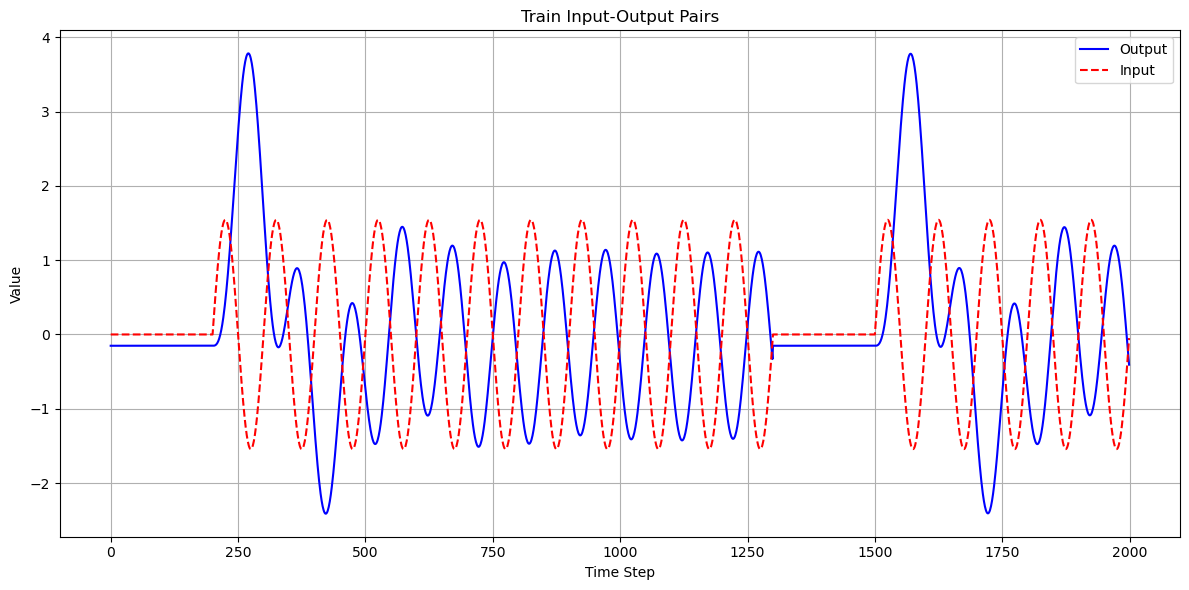

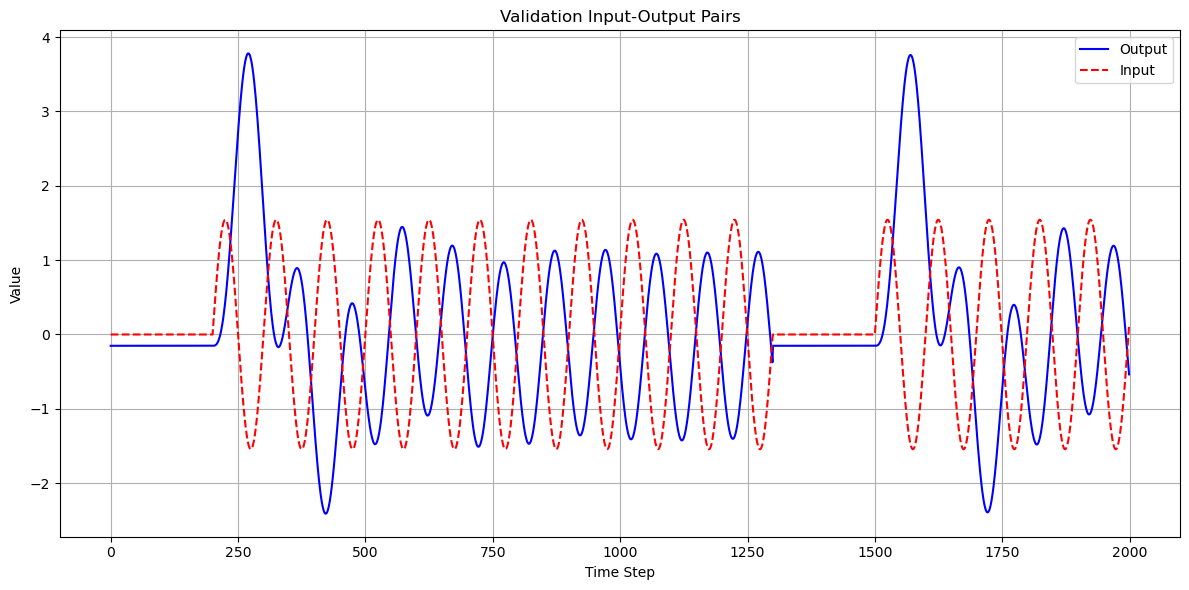

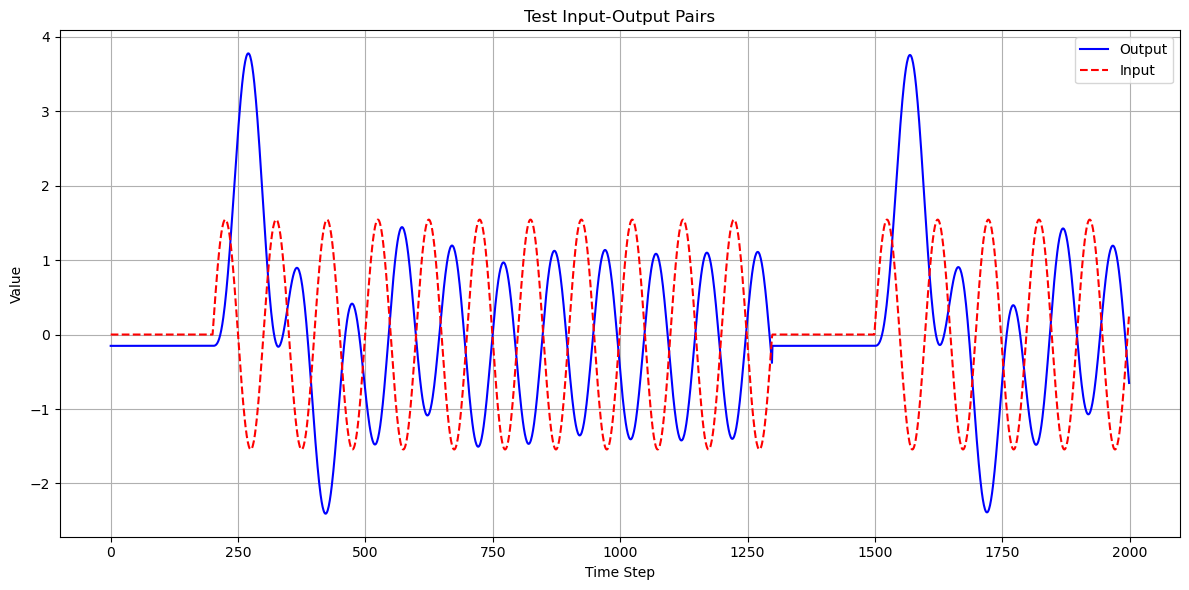

In [14]:
def plot_input_output_pairs(input_data, output_data, title, start=0, end=2000):
	plt.figure(figsize=(12, 6))
	plt.plot(output_data[start:end], label='Output', color='blue')
	plt.plot(input_data[start:end], label='Input', color='red', linestyle='--')
	plt.title(f'{title} Input-Output Pairs')
	plt.xlabel('Time Step')
	plt.ylabel('Value')
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

# Example usage:
plot_input_output_pairs(train_input, train_output, 'Train')
plot_input_output_pairs(val_input, val_output, 'Validation')
plot_input_output_pairs(test_input, test_output, 'Test')

### Train

In [15]:
model = DynamicalSystemModel(model_type, 1, hidden_size, num_layers, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

DynamicalSystemModel(
  (net): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


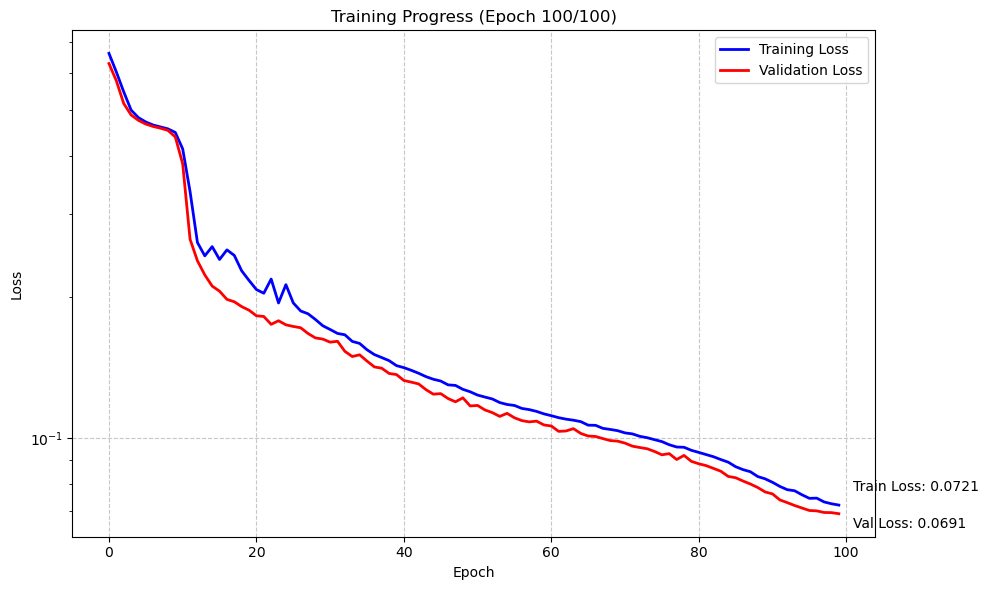

Training Epochs: 100%|██████████| 100/100 [3:02:47<00:00, 109.68s/it]


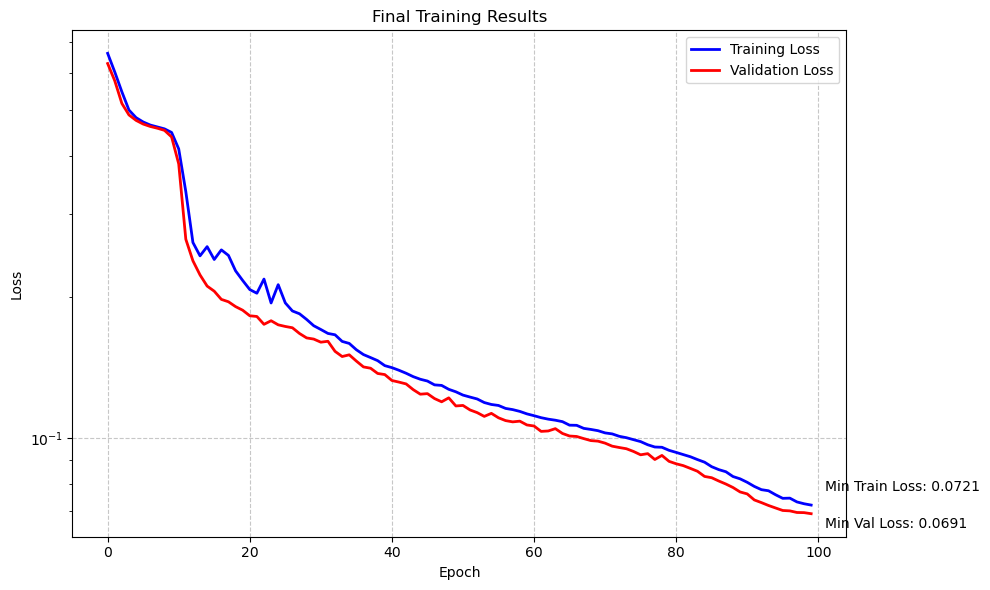

In [19]:
train_losses, val_losses = train_model(
    model.to(device),
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    folder=f"{base_folder}/pytorch_models"
)

## Testing

In [20]:
model = DynamicalSystemModel(model_type, 1, hidden_size, num_layers, 1)
folder = f"{base_folder}/pytorch_models"
model.load_state_dict(torch.load(f'{folder}/{model.str_id()}.pth', weights_only=True))
model.to(device)
print(model)

DynamicalSystemModel(
  (net): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


### Test Set Loss & Predictions

In [21]:
# test the model
model.eval()
test_losses = []
with torch.no_grad():
    for in_data, out_data in test_loader:
        in_data, out_data = in_data.to(device), out_data.to(device)
        model_output = model(in_data)
        loss = criterion(model_output.unsqueeze(1), out_data)
        test_losses.append(loss.item())
        
print(f'Test Loss: {np.mean(test_losses):.4f}')

Test Loss: 0.0691


### Visualize Predictions

In [22]:
def generate_predictions(model, input_data, output_data, lookback_len, device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        # We can only start predicting after we have enough history
        for i in range(len(input_data) - lookback_len):
            # Get input sequence
            input_seq = input_data[i:i + lookback_len]

            # Prepare input tensor
            input_tensor = torch.FloatTensor(input_seq).unsqueeze(0).to(device)

            # Make prediction
            pred = model(input_tensor)
            predictions.append(pred.cpu().numpy()[0][0])

            # Get corresponding actual value
            actuals.append(output_data[i + lookback_len][0])

    return np.array(predictions), np.array(actuals)

def plot_predictions(predictions, actuals, title="Model Predictions vs Actual Values", samples=range(1,1000)):
    plt.figure(figsize=(12, 6))

    # Plot only the specified number of samples for clarity
    x = np.arange(len(predictions))[samples]
    plt.plot(x, actuals[samples], label='Actual', color='blue')
    plt.plot(x, predictions[samples], label='Predicted', color='red', linestyle='--')

    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_metrics(predictions, actuals):
    mae = np.mean(np.abs(predictions - actuals))	# mean absolute error
    mse = np.mean((predictions - actuals)**2)		# mean squared error
    rmse = np.sqrt(mse)								# root mean squared error
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100		# mean absolute percentage error
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

In [23]:
# generate predictions
predictions, actuals = generate_predictions(
    model=model,
    input_data=test_input,
    output_data=test_output,
    lookback_len=lookback_len,
    device=device
)

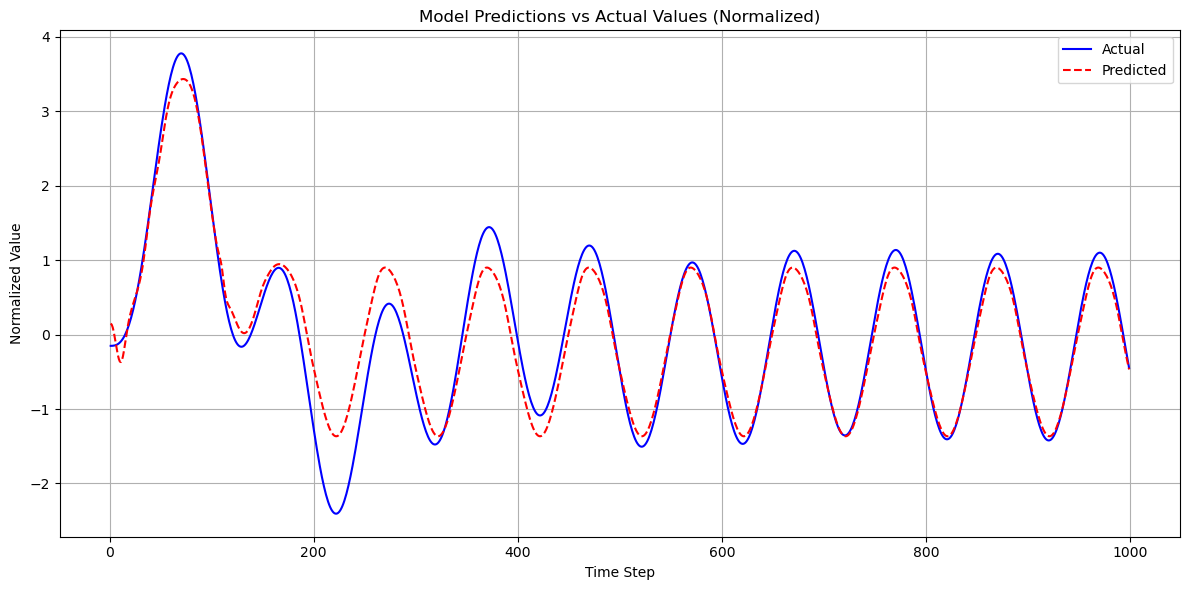

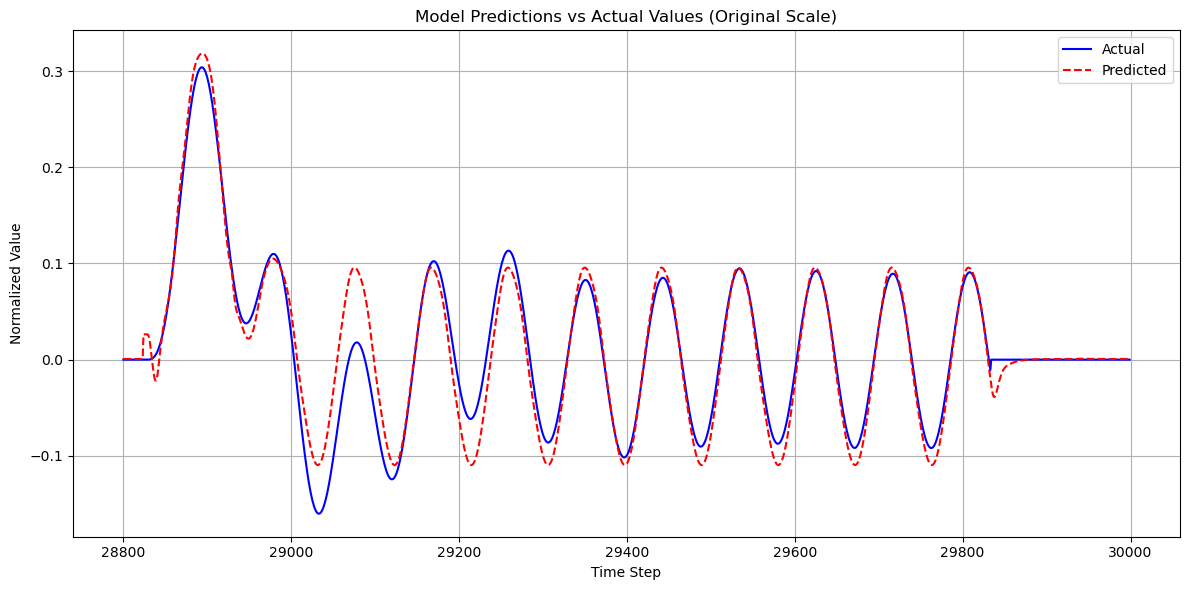

MAE: 0.1618
MSE: 0.0691
RMSE: 0.2629
MAPE: 217.9797


In [24]:
# Plot normalized results
plot_predictions(predictions, actuals, title="Model Predictions vs Actual Values (Normalized)", samples=range(1,1000))

# Plot in original scale
predictions_original = output_scaler.inverse_transform(predictions.reshape(-1, 1))
actuals_original = output_scaler.inverse_transform(actuals.reshape(-1, 1))
plot_predictions(
    predictions_original,
    actuals_original,
    title="Model Predictions vs Actual Values (Original Scale)",
    samples=range(total_samples*(len(test_freq)-1),total_samples*(len(test_freq)-0))
)

metrics = calculate_metrics(predictions, actuals)
for metric, value in metrics.items():
	print(f'{metric}: {value:.4f}')